In [177]:
# pip install pydot
# pip install scikit-learn
# pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint
from sklearn.tree import export_graphviz
import pydot
from matplotlib import pyplot as plt
import joblib

In [2]:
#assess the efficacy of the hyperparameter search
def evaluate(model, test_features, test_labels,name):
    predictions = model.predict(test_features)
    np.savetxt("/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/random_forest/outputs/" + name +"_current_predictions_chagas_density.csv", predictions, delimiter=",",  header = 'PROJECTED_CASES')
    errors = abs(predictions - test_labels)
    mae = np.mean(errors) #couldnt use mape as have zero values for many data points
    statistics = pd.DataFrame(errors).describe()
    plt.figure()
    plt.scatter(test_labels,predictions)
    # pprint(statistics)
    # print('Model Performance')
    # print('Average Error: {:0.4f} cases.'.format(mae))
    
    return mae, statistics

In [6]:
#reading in data and splitting variables from labels
features = pd.read_csv('/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/data/random_forest_input/colombia/rf_current_input_chagas_density.csv').iloc[:,2:]

pprint(features.describe())

#identify the labels, i.e. the value to predict and remove it from the total cases
labels = np.array(features["CASES_DENSITY"])
features = features.drop(['TOTAL_CASES', 'SUITABILITY_MEDIAN', 'CASES_DENSITY'], axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)
print(feature_list)
print(labels)

#convert to numpy array
features = np.array(features)

               SVI      POP_DENS  SUITABILITY_MEAN  SUITABILITY_MEDIAN  \
count  1122.000000   1122.000000       1122.000000         1122.000000   
mean      0.003273    147.218108          0.486161            0.485076   
std       0.629838    641.930166          0.204276            0.213544   
min      -2.413090      0.058054          0.050715            0.039474   
25%      -0.396850     18.522147          0.337110            0.339603   
50%      -0.024184     38.747537          0.508514            0.508180   
75%       0.435019     82.092719          0.636701            0.639794   
max       2.317944  12498.025239          0.965954            0.989610   

       TOTAL_CASES  CASES_DENSITY  
count  1122.000000    1122.000000  
mean      3.353832       0.000250  
std      16.578431       0.001042  
min       0.000000       0.000000  
25%       0.000000       0.000000  
50%       0.000000       0.000000  
75%       1.000000       0.000061  
max     327.000000       0.014163  
['SVI', '

(array([1.07e+03, 3.00e+01, 7.00e+00, 6.00e+00, 2.00e+00, 2.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 2.00e+00]),
 array([0.        , 0.00141632, 0.00283264, 0.00424895, 0.00566527,
        0.00708159, 0.00849791, 0.00991422, 0.01133054, 0.01274686,
        0.01416318]),
 <BarContainer object of 10 artists>)

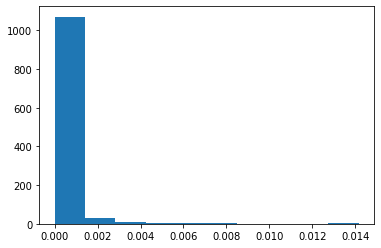

In [8]:
#visualising the spread of data
# labels_no_zero = labels[labels !=0]
# min_val = min(labels_no_zero)
# print(list(labels).count(0))
data = labels
# zero_bin = [0,min_val]
# print(zero_bin)
# rest_of_bins = list(np.arange(min_val, 0.014163,(0.014163-min_val)/10))
# bins = zero_bin + rest_of_bins
plt.hist(data)

In [9]:
#split the data into training and testing
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42) #remove 42 in final run but just used when testing code

In [10]:
#write the data to a file for future analysis
# np.savetxt('/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/data/random_forest_input/colombia/train_features_chagas_density.csv',train_features, delimiter=",", header = 'TRAIN_FEATURES')
# np.savetxt('/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/data/random_forest_input/colombia/test_features_chagas_density.csv',test_features, delimiter=",", header = 'TEST_FEATURES')
# np.savetxt('/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/data/random_forest_input/colombia/train_labels_chagas_density.csv', train_labels,delimiter=",", header = 'TRAIN_LABELS')
# np.savetxt('/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/data/random_forest_input/colombia/test_labels_chagas_density.csv', test_labels,delimiter=",", header = 'TEST_LABELS')

In [11]:
#which hyperparameters can i tune?
rf = RandomForestRegressor(random_state = 42)
print('Parameters currently in use:\n')
pprint(rf.get_params())


Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [6]:
#set the range of hyperparameter options to consider
bootstrap = [True]
# ccp_alpha = [i for i in np.linspace(start = 0, stop = 0.05, num = 50)] 
ccp_alpha = [0]
max_features = [1,2,3]
max_samples = [i for i in np.linspace(start = 0, stop = 0.3, num = 50)]

#create the random grid 
random_grid = {'max_samples': max_samples,
               'max_features': max_features,
               'ccp_alpha': ccp_alpha,
               'bootstrap': bootstrap}

# pprint(random_grid)

In [95]:
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor(oob_score=True)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
rf_random.fit(train_features, train_labels)
rf_random.best_params_

/Users/laurengomezcullen/opt/anaconda3/envs/python_Env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/laurengomezcullen/opt/anaconda3/envs/python_Env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/laurengomezcullen/opt/anaconda3/envs/python_Env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 385, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/Users/laurengomezcullen/opt/anac

{'max_samples': 0.1346938775510204,
 'max_features': 1,
 'ccp_alpha': 0,
 'bootstrap': True}

Improvement of 22.60%. from no bootstrapping
Improvement of 4.36%. from bootstrapping before random check


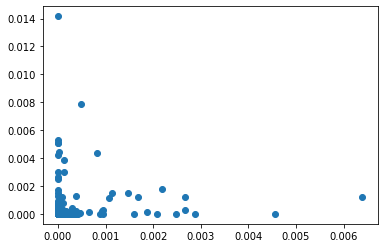

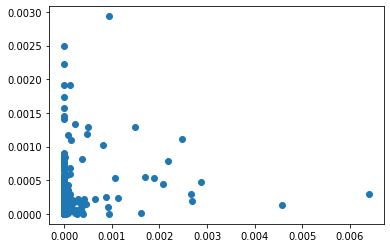

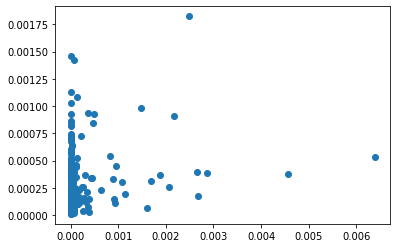

In [12]:
# base_model = RandomForestRegressor(bootstrap = False, random_state = 42)
base_model = joblib.load("/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/random_forest/outputs/base_model_chagas_density.joblib")
base_model.fit(train_features, train_labels)
base_mae, base_stats = evaluate(base_model, test_features, test_labels, "base")
# joblib.dump(base_model, "/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/random_forest/outputs/base_model_chagas_density.joblib")

# base_model_boot = RandomForestRegressor(random_state = 42, oob_score=True)
base_model_boot = joblib.load("/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/random_forest/outputs/base_model_boot_chagas_density.joblib")
base_model_boot.fit(train_features, train_labels)
base_mae_boot, base_mae_boot_stats = evaluate(base_model_boot, test_features, test_labels, "base_boot")
# print('base with boot oob prediction: ' + str(base_model_boot.oob_prediction_))
#print('base with boot oob: ' + str(base_model_boot.oob_score_))
# joblib.dump(base_model_boot, "/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/random_forest/outputs/base_model_boot_chagas_density.joblib")

# best_random = rf_random.best_estimator_
best_random = joblib.load("/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/random_forest/outputs/best_random_chagas_density.joblib")
random_mae, random_stats = evaluate(best_random, test_features, test_labels, "random_base")
# joblib.dump(best_random, "/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/random_forest/outputs/best_random_chagas_density.joblib")
# print('random oob prediction: ' + str(best_random.oob_prediction_))
# print('random_mae error: ' + str(random_mae))
# print('random oob: ' + str(best_random.oob_score_))
print('Improvement of {:0.2f}%. from no bootstrapping'.format( 100 * (base_mae-random_mae) / base_mae))
print('Improvement of {:0.2f}%. from bootstrapping before random check'.format( 100 * (base_mae_boot-random_mae) / base_mae))

In [111]:
#now try to fine tune

# Create the parameter grid based on the results of random search 
param_grid = {'max_samples': [i for i in np.linspace(start = 0, stop = 0.3, num = 50)],
               'max_features': [1],
               'ccp_alpha': [0]
               }
            #    0.2631578947368421

# [0.2631578947368421]

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1)

# Fit the grid search to the data
grid_search.fit(train_features, train_labels)
best_grid = grid_search.best_estimator_
print(best_grid)

RandomForestRegressor(ccp_alpha=0, max_features=1,
                      max_samples=0.12857142857142856)


/Users/laurengomezcullen/opt/anaconda3/envs/python_Env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/laurengomezcullen/opt/anaconda3/envs/python_Env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/laurengomezcullen/opt/anaconda3/envs/python_Env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 385, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/Users/laurengomezcullen/opt/anac

Improvement of 25.76%.
0.00030911048921481013
0.0001770563159803809


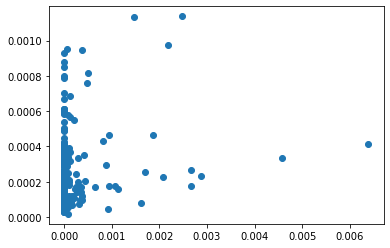

In [11]:
#evaluate the grid performance
best_grid = joblib.load("/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/random_forest/outputs/best_grid_chagas_density.joblib")
grid_mae, grid_stats = evaluate(best_grid, test_features, test_labels, "final")
print('Improvement of {:0.2f}%.'.format( 100 * (base_mae_boot-grid_mae) / base_mae))
print(grid_mae)
print(np.mean(test_labels))
# joblib.dump(best_grid, "/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/random_forest/outputs/best_grid_chagas_density.joblib")
#little improvement so no more adjusting. the improvement lay within the range I would observe when just excecuting the same value as before again. 


In [121]:
# create prediction for entire country using model
grid_mae = evaluate(best_grid, features, labels, "final_entire_country")

In [40]:
np.loadtxt("/Users/laurengomezcullen/Documents/Cambridge/Fourth/Project/final/random_forest/outputs/final_entire_country_current_predictions.csv")

array([8.28528788, 5.63489286, 4.06129437, ..., 3.90876696, 6.15389683,
       2.86983838])